In [1]:
#Librerias de matplotli
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d #Esto es para realizar gráficas en 3D
import pandas as pd 
import numpy as np 
import scipy as sci 
import sympy as sp
from scipy.interpolate import interp1d,splrep,splev,interpn #Esto es para poder realizar la interpolación 
#Para realizar la cinemática de multicuerpos
from pytransform3d import rotations as pr_rot
from pytransform3d import plot_utils as pr_plot
import pytransform3d.transformations as pr_trans
import math as mt

# Wind Loading on the Hay-Stack Radiotelescope

## Aerodynamic Coefficients of Parabolic Antenas 

Para el calculo de las cargas aerodinámicas que resiste la  antena parabolica utilizada en el radiotelescopio Hay-Stack se utilizó la data y recomendaciones presentadas en los siguientes articulos: 

(1)[Roschke, E. J. (1984). Wind loading on solar concentrators: some general considerations (No. DOE/JPL-1060-66; JPL-PUB-83-101). Jet Propulsion Lab., Pasadena, CA (USA).](https://www.osti.gov/biblio/6517833 "Wind loading on solar concentrators")

(2)[Wyatt, T. A. (1964). The aerodynamics of shallow paraboloid antennas. Annals of the New York Academy of Sciences, 116(1), 222-238.](https://nyaspubs.onlinelibrary.wiley.com/doi/abs/10.1111/j.1749-6632.1964.tb33945.x "Aerodynamics of Shallow paraboloid antennas" )

(3)[Levy, R., & Kurtz, D. W. (1978). Compilation of wind tunnel coefficients for parabolic reflectors. ](https://core.ac.uk/download/pdf/42874561.pdf "Compilation of wind tunnel coefficients for parabolic reflectors")

Los tres documentos anteriormente presentados representan un referente en el cálculo de cargas aerodinámicas en antenas parabolicas, los datos que en estos se encuentran, son producto de simulaciones en tunel de viento de antenas recreadas a escala cuyos parámetros de semejanza geométrica son: <!-- spaces -->
* Razón Focal: (F/D)
* Razón de altura: (H/D) 
* Porosidad: 0\%, 25\%, 50\% 

Como longitud carácteristica de la antena se tiene su diámetro, y como área de referencia se tiene el área frontal $\frac{\pi D^{2}}{4} $



## Hay-Stack Paraboloid Antenna

Las caracteristicas geométricas de la antena Parabolica del radiotelescopio Hay-Stack se presentan a continuación: 
* Diámetro: 3 metros
* Distancia Focal: 1.35 m
* Altura: 41.6 cm
* Razón Focal (F/D): 0.45
* Rázon de altura (H/D): 0.138 
* Porosidad estimada: 50% 

In [2]:
    #Parámetros geométricos de la antenna 
    
D = 3 #Diámetro: 3 metros 
f = 1.35 #Distancia Focal: 1.35 m
h = 0.416 #Altura: 41.6 cm
FD = 0.45 #Razón Focal (F/D): 0.45
HD = 0.138 #Rázon de altura (H/D): 0.138 
e = 2*f*(1 +(D/(2*f))**2)
A_ref = (mt.pi*D**2)/4 #Área de refencia de la antena
ED = e/D

#Porosidad estimada: 50% 

#### Datos de los coeficientes aerodinámicos de una antena con razón focal de 0.46 y porosidad 0

A continuación se realiza el tratamiento de datos de los archivos .csv para obtener la data que ahí se presenta, los datos de los coeficientes de carga axial están en el DataFrame Axial_coeff y los de carga transversal (o lateral) están en Lat_coeff

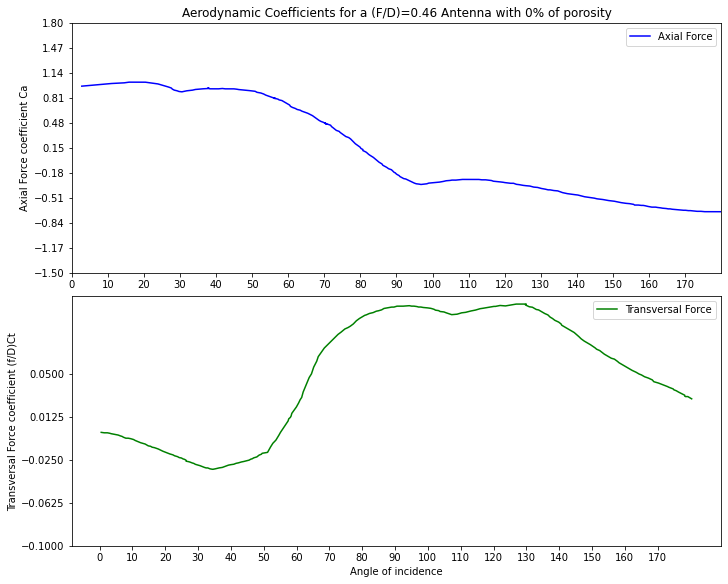

In [3]:
    ##Lectura de los coeficientes de la fuerza axial obtenidos en [2]
    
axial_coeff_csv = 'Axialforcecoeff046.csv' 
#Lee el archivo .csv en donde se tiene para diferentes ángulos el coeficiente 
axial_coeff = pd.read_csv(axial_coeff_csv, sep= ';', names = ["Gamma", "Ca"], header = 0)

#Convierte los objetos de las columnas al tipo de objeto más adecuado en este caso a String
Axial_coeff = axial_coeff.convert_dtypes()
#Axial_coeff.dtypes

#Se remplaza la , por . para que se pueda realizar la conversión a punto flotante
Axial_coeff["Gamma"]= Axial_coeff["Gamma"].str.replace(',','.').astype(float)
Axial_coeff["Ca"]= Axial_coeff["Ca"].str.replace(',','.').astype(float)
#Se verifica que el tipo de dato sea float
#Axial_coeff.dtypes

Gamma_ca = np.array(Axial_coeff["Gamma"])
Ca = np.array(Axial_coeff["Ca"])

                        ##Lectura de los coeficientes de la fuerza alateral obtenidos en [2]
    
lat_coeff_csv = 'Lat_force_coeff046.csv' 
#Lee el archivo .csv en donde se tiene para diferentes ángulos el coeficiente 
lat_coeff = pd.read_csv(lat_coeff_csv, sep= ';', names = ["Gamma", "Ct"], header = 0)

#Convierte los objetos de las columnas al tipo de objeto más adecuado en este caso a String
Lat_coeff = lat_coeff.convert_dtypes()
Lat_coeff.dtypes

#Se remplaza la , por . para que se pueda realizar la conversión a punto flotante
Lat_coeff["Gamma"]= Lat_coeff["Gamma"].str.replace(',','.').astype(float)
Lat_coeff["Ct"]= Lat_coeff["Ct"].str.replace(',','.').astype(float)
# #Se verifica que el tipo de dato sea float
#Lat_coeff.dtypes

Gamma_ct = np.array(Lat_coeff["Gamma"])
Ct = np.array(Lat_coeff["Ct"])
    
                        ##Gráficas de los coeficientes [2]

#Se gráfican en dos subplots                    
fig = plt.figure(figsize =(10,8),constrained_layout = True)
#Se divide la figura en una rejilla de 2 filas x 1 columna
gs = fig.add_gridspec(2,1)

#Se crean las dos subgraficas fuerza axial (ax_force) y fuerza lateral (lat_forc), 
#como ejemplo se dice que ax_force utilice el espacio de la rejilla en los espacios fila 1 colomna 1
ax_forc = fig.add_subplot(gs[0,0])
lat_forc = fig.add_subplot(gs[1,0])

                        #Se Gráfica el coeficiente de fuerza axial 
#Se pone el titulo a las dos gráficas
ax_forc.set_title("Aerodynamic Coefficients for a (F/D)=0.46 Antenna with 0% of porosity")
#Se gráfica el coeficiente aerodinámico
ax_forc.plot(Gamma_ca,Ca, color = 'blue', label = 'Axial Force')
#Para que salgan las legendas
ax_forc.legend()
#Se pone el titulo del eje y
ax_forc.set_ylabel('Axial Force coefficient Ca')
#Se establece la escala de la gráfica
ax_forc.set(xlim=(0,180))
#Se cambian los ticks de los ejes 
ax_forc.set_xticks(range(0,180,10))
ax_forc.set_yticks(np.linspace(-1.5,1.8,11))
                        #Se Gráfica el coeficiente de fuerza trasnversal
#Se gráfica el coeficiente aerodinámico
lat_forc.plot(Gamma_ct,Ct, color = 'green', label = 'Transversal Force')
#Para que salgan las legendas
lat_forc.legend()
#Se pone el titulo del eje y y del eje x (el cual es compartido)
lat_forc.set_ylabel('Transversal Force coefficient (f/D)Ct')
lat_forc.set_xlabel('Angle of incidence')
#Se cambian los ticks de los ejes 
lat_forc.set_xticks(range(0,180,10))
lat_forc.set_yticks(np.linspace(-0.1,0.05,5))



#### Interpolación de los datos anteriorimente suministrado

Con el fin de obtener los valores de los coeficientes aerodinámicos para cualquier ángulo de incidencia se propone una interpolación lineal de una dimensión mediante el [método de scipy](https://scipy.github.io/devdocs/tutorial/interpolate.html#spline-interpolation-in-1-d-object-oriented-univariatespline "Interpolación 1D") de los coeficientes Ca y Ct 

Debido a que se pueden interpolar valores de angulo de incidencia $\gamma$ que estén entre los rangos originales encontrados en los dataframes se deja como conocimiento que: 
* Para Ca $\rightarrow$ $\gamma \in \left[1.4723 , 180.85 \right]$
* Para Ct $\rightarrow$ $\gamma \in \left[0.23, 179.52  \right]$

Por lo que se propone la evaluación de las cargas en el intervalo $\gamma \in \left[2,179 \right]$

#### Interpolación para el coeficiente de fuerza Axial

Text(0.5, 1.0, 'Interpolación 1D para los datos de coeficientes de fuerza Axial')

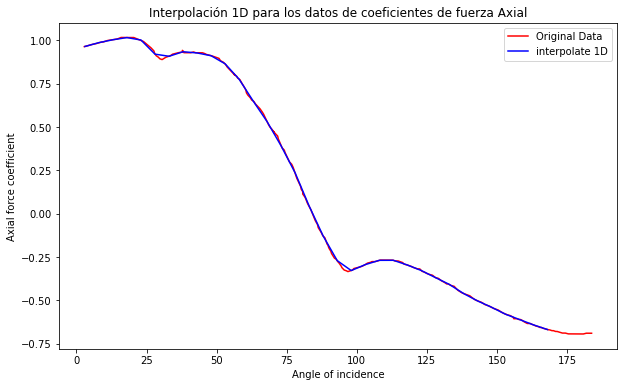

In [4]:
                                        #Interpolación de los datos del coeficiente de carga axial
#Se realiza la interpolación a partir de los datos
f_af = interp1d(Gamma_ca, Ca, kind = "cubic") #Utilizando una interpolación cubica 
#Se crea una lista para evaluaar la interpolación 
Gamma_test = range(3,170,5)
#Gráfica de la interpolación para los ángulos Gamma test
fig3 = plt.figure(figsize =(10,6)) 
ax = plt.subplot()
ax.plot(Gamma_ca,Ca,color = 'red', label = 'Original Data')
ax.plot(Gamma_test,f_af(Gamma_test), color = 'blue', label ='interpolate 1D')
ax.legend()
ax.set_xlabel("Angle of incidence")  
ax.set_ylabel("Axial force coefficient")
ax.set_title("Interpolación 1D para los datos de coeficientes de fuerza Axial")


#### Interpolación para el coeficiente de fuerza Lateral o transversal

Text(0.5, 1.0, 'Interpolación 1D para los datos de coeficientes de fuerza Lateral')

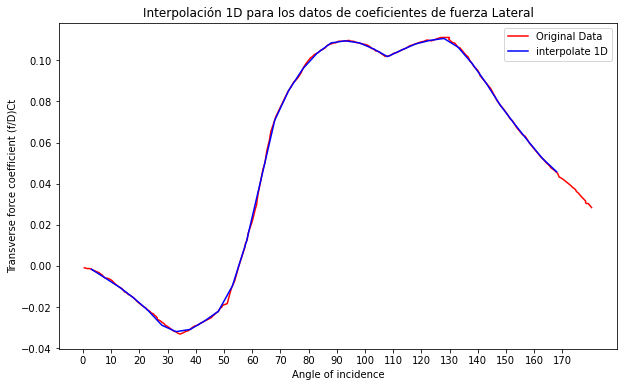

In [5]:
                                        #Interpolación de los datos del coeficiente de carga lateral
#Se realiza la interpolación a partir de los datos
f_al = interp1d(Gamma_ct, Ct, kind = "cubic")
#Se utiliza la misma lista de interpolación utilizada para el coeficiente de carga axial
#Gráfica de la interpolación para los ángulos Gamma test
fig3 = plt.figure(figsize =(10,6)) 
ax = plt.subplot()
ax.plot(Gamma_ct,Ct,color = 'red', label = 'Original Data')
ax.plot(Gamma_test,f_al(Gamma_test), color = 'blue', label ='interpolate 1D')
ax.set_xticks(range(0,180,10))
ax.legend()
ax.set_xlabel("Angle of incidence")
ax.set_ylabel("Transverse force coefficient (f/D)Ct")
ax.set_title("Interpolación 1D para los datos de coeficientes de fuerza Lateral")

#### Comprobación de los coeficientes aerodinámicos respecto a los coeficientes cálculados 

Es importante ver que tan preciso es asumir la antena del radiotelescopio Hay-Stack como una antena completamente sólida, para ello se va a verificar algunos coeficientes; para esto se toman como referencia los coeficientes aerodinámicos acá calculados y se compararán con los dados en la referencia [3].

La metodología a emplear es la siguiente: 
* Se plantean varios ángulos de azimuth y elevación
* Se cálcula el verdadero ángulo de incidencia $ Cos(\gamma) = Cos(\alpha)sin(\beta)$ en donde $\alpha$ es el ángulo de azimuth y $\beta$ es el ángulo de elevación.
* Se cálculan las fuerzas arodinámicas en la Antenna en el Steering Axis (Stability Axis) y posteriormente se    cálculan los coeficientes aerodinámicos
* Se listan los coeficientes aerodinámicos propuestos en [3] para los ángulos de elevación y azimuth
* Se transladan todos al mismo sistema de referencia ( Body Axis $\longleftrightarrow$ Steering  Axis) 

In [6]:
        #Comprobación de los coeficientes aerodinámicos respecto a los coeficientes cálculados
    #Se listan ángulos de azimuth y elevación 

alpha = np.array(range(5,350,5))#Angulos de azimut
beta = np.array(range(0,90,5))# Angulos de elevacion

    #Se crea un arreglo de attitude para tener las diferentes combinaciones de posición
attitude = np.empty((len(alpha),len(beta)))
for i in range(len(alpha)):
    attitude[i,:] = beta
    #Se crea un DataFrame con todas las posiciones de la antena
attitude_df = pd.DataFrame(attitude, index = alpha)
attitude_df = attitude_df.T
attitude_df.index = beta  


    #Se crea un arreglo de los ángulos de incidencia equivalentes 
gamma = np.empty((len(alpha),len(beta)))
for i in range(len(alpha)):
    gamma[i,:] = np.rad2deg(np.arccos(mt.cos(mt.radians(alpha[i]))*np.sin(np.deg2rad(attitude[i,:]))))
    
gamma_df = pd.DataFrame(gamma, index = alpha) #Las filas son el ángulo de azimuth y se le asigna valor
gamma_df = gamma_df.T    #Se transpone para que ahora las filas sean los angulos de elevacion                                  
gamma_df.index = beta    #Se le pone el valor de cada fila
#print(gamma_df)    #descomentar para ver la relación de ángulos con ángulos equivalentes 

                    #Se cálcula los coeficientes de fuerza axial para cada posición de la antena

Ax_coef_att = f_af(gamma_df) #Se calcula un array con los coeficientes
Ax_coef_df = pd.DataFrame(Ax_coef_att, index = beta) #Se transforma a dataframe y se asigna a las filas el valor de la eleavacion
Ax_coef_df = Ax_coef_df.T  #Ahora las filas son los ángulos de azimuth
Ax_coef_df.index = alpha   #Se le da el valor de azimuth a cada fila
Ax_coef_df = Ax_coef_df.T  #Se devuelve a su posicion normal (columnas = azimuth) paa que coincida con gamma

                     #Se cálcula los coeficientes de fuerza lateral para cada posición de la antena
#Se realiza el mismo procedimeinto que con la fuerza axial
Lat_coef_att = f_al(gamma_df)
Lat_coef_df = pd.DataFrame(Lat_coef_att, index = beta)
Lat_coef_df = Lat_coef_df.T 
Lat_coef_df.index = alpha 
Lat_coef_df = Lat_coef_df.T 

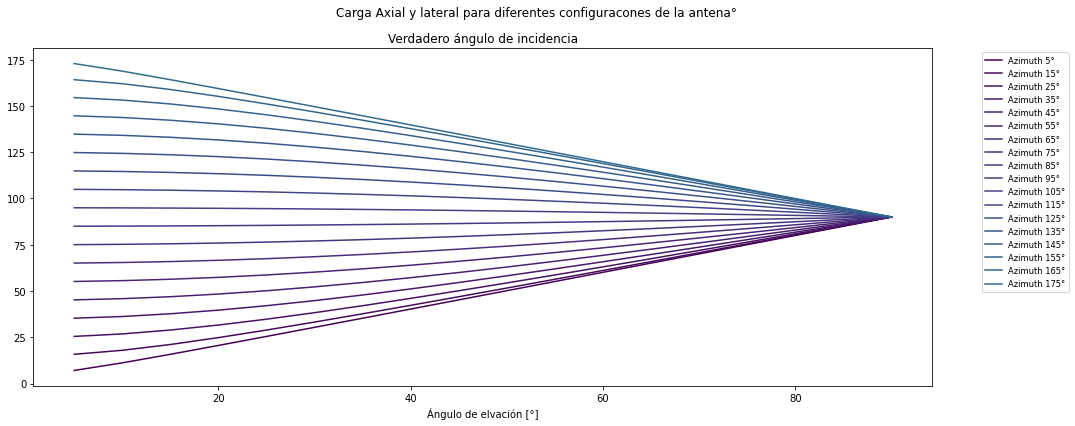

In [7]:
                                #Gráfica del verdadero ángulo de incidencia
fig = plt.figure(figsize=(15,6), tight_layout = True)

fig.suptitle("Carga Axial y lateral para diferentes configuracones de la antena°")
gamma_plt = fig.add_subplot()

ilist = range(0,35,2)
#se crea la paleta de colores a partir de cmap 'viridis'
cmap=plt.get_cmap('viridis')
pallete = []
for n in np.linspace(0,1,100):
    pallete.append(cmap(n))

for i in ilist:
    gamma_plt.plot(90-beta,gamma[i,:], label = "Azimuth " + str(alpha[i])+"°",color = pallete[i])
    gamma_plt.set_xlabel("Ángulo de elvación [°]")
    gamma_plt.legend(bbox_to_anchor=(1.05, 1.0), loc = 2,fontsize='small')
    gamma_plt.set_title("Verdadero ángulo de incidencia")

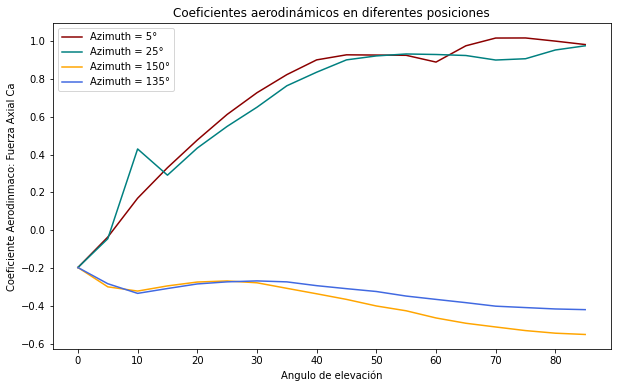

In [8]:
                    #Se Grafican el coeficiente aerodinámicos de fuerza axial para cada posición de la antena
fig = plt.figure(figsize =(10,6)) 
ax = plt.subplot()
ax.plot(Ax_coef_df.index,Ax_coef_df.loc[:,5], color = 'darkred', label ="Azimuth = 5°")
ax.plot(Ax_coef_df.index,Ax_coef_df.loc[:,25], color = 'teal', label ="Azimuth = 25°")
ax.plot(Ax_coef_df.index,Ax_coef_df.loc[:,150], color = 'orange', label ="Azimuth = 150°")
ax.plot(Ax_coef_df.index,Ax_coef_df.loc[:,135], color = 'royalblue', label ="Azimuth = 135°")

ax.set_xlabel("Angulo de elevación")
ax.set_ylabel("Coeficiente Aerodinmaco: Fuerza Axial Ca")
ax.set_title("Coeficientes aerodinámicos en diferentes posiciones")
ax.set_xticks(range(0,90,10))
ax.legend()

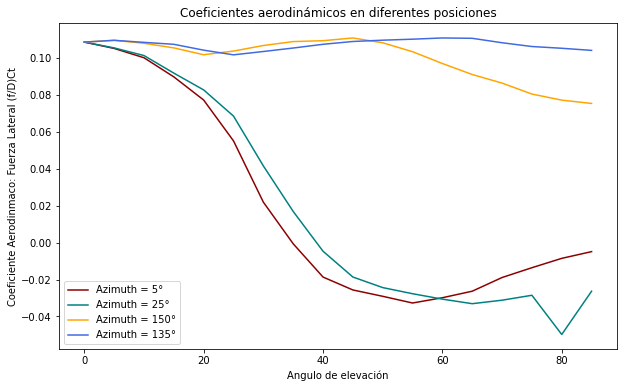

In [9]:
                    #Se Grafican el coeficiente aerodinámicos de fuerza lateral para cada posición de la antena
fig = plt.figure(figsize =(10,6)) 
ax = plt.subplot()
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,5], color = 'darkred', label ="Azimuth = 5°")
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,25], color = 'teal', label ="Azimuth = 25°")
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,150], color = 'orange', label ="Azimuth = 150°")
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,135], color = 'royalblue', label ="Azimuth = 135°")

ax.set_xlabel("Angulo de elevación")
ax.set_ylabel("Coeficiente Aerodinmaco: Fuerza Lateral (f/D)Ct")
ax.set_title("Coeficientes aerodinámicos en diferentes posiciones")
ax.legend()

Con el fin de obtener el coeficiente de fuerza lateral neto $C_{t}$ y no $\left(\frac{f}{D}\right) C_{t}$ se debe multiplicar por el inverso de la razón focal el coeficiente aerodinámico, así pues:

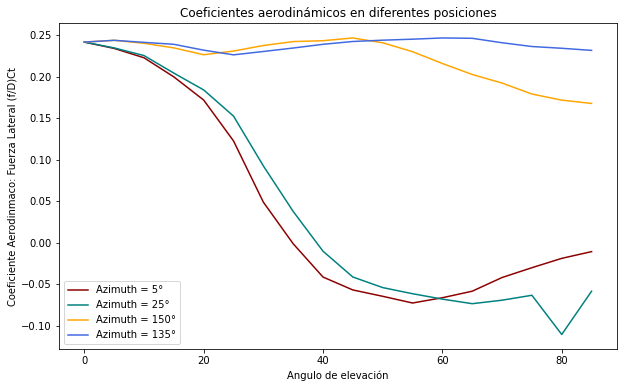

In [10]:
Lat_coef_df = (1/FD)*Lat_coef_df
fig = plt.figure(figsize =(10,6)) 
ax = plt.subplot()
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,5], color = 'darkred', label ="Azimuth = 5°")
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,25], color = 'teal', label ="Azimuth = 25°")
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,150], color = 'orange', label ="Azimuth = 150°")
ax.plot(Lat_coef_df.index,Lat_coef_df.loc[:,135], color = 'royalblue', label ="Azimuth = 135°")

ax.set_xlabel("Angulo de elevación")
ax.set_ylabel("Coeficiente Aerodinmaco: Fuerza Lateral (f/D)Ct")
ax.set_title("Coeficientes aerodinámicos en diferentes posiciones")
ax.legend()

El  primer cáculo de fuerzas que a continuación se presenta corresponde a las fuerzas representadas en un sistema de referencia local del tipo Stability Axes o Steering axis, el cual se presenta en la siguiente imagen: 
<img src="Stability_Axes.JPG">
Este sistema de referencia de acá en adelante se conoce como sistema de referencia 0 S0 y debe ser convertido al sistema de coordenadas S3 que posteriormente se presenta para poder realizar comparaciones con [3]

## Descripción de los sistemas de referencia utilizados

A continuación se pesentará la descripción de los sistemas de referencia utilizados, para ellos es importante tener en cuenta los colores de los ejes siendo: 
* Rojo: Eje x positivo 
* Verde: Eje y positivo
* Azul: Eje z positivo 

#### Sistema de Corrdenadas 0 S0
En este sistema de coordenadas cada eje representa 
* Eje y: Representa el eje de elevación
* Eje x: Perpedincular al eje de elevación en un plano vertical
* Eje z: Eje vertical 

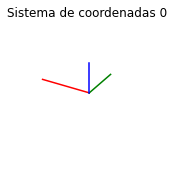

In [11]:
fig = plt.figure(figsize=(2,2))
ax0 = pr_rot.plot_basis(R=np.eye(3))
ax0.set_xlim((0.8,-0.8))
ax0.set_title("Sistema de coordenadas 0")
pr_plot.remove_frame(ax0)
plt.show()

#### Sistema de Cordenadas S1
En este sistema de coordenadas cada eje representa 
* Eje y: Perpedincular al eje de elevación en un plano vertical
* Eje x: Representa el eje de elevación 
* Eje z: Eje vertical 

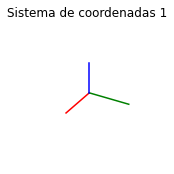

In [12]:
fig = plt.figure(figsize=(2,2))
R = pr_rot.matrix_from_axis_angle(a=[0,0,1,-np.pi/2])
ax1 = pr_rot.plot_basis(R = R)
pr_plot.remove_frame(ax1)
ax1.set_title("Sistema de coordenadas 1")
plt.show()

#### Sistema de Corrdenadas 0 S2
En este sistema de coordenadas cada eje representa 
* Eje y: Representa el eje de elevación 
* Eje x: Representa el eje de elevación Eje vertical 
* Eje z: Perpedincular al eje de elevación en un plano horizontal

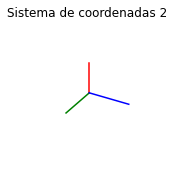

In [13]:
fig = plt.figure(figsize=(2,2))
R = np.array([
    [0,0,1],
    [0,-1,0],
    [1,0,0]
])
ax2 = pr_rot.plot_basis(R = R)
pr_plot.remove_frame(ax2)
ax2.set_title("Sistema de coordenadas 2")
plt.show()

#### Sistema de Corrdenadas 0 S3 (Body Frame)
En este sistema de coordenadas cada eje representa 
* Eje y: Perpedincular al eje de elevación en un plano horizontal
* Eje x: Eje vertical 
* Eje z: Representa el eje de elevación

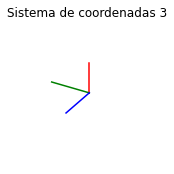

In [14]:
fig = plt.figure(figsize=(2,2))
R = np.array([
    [0,-1,0],
    [0,0,-1],
    [1,0,0]
])
ax3 = pr_rot.plot_basis(R = R)
pr_plot.remove_frame(ax3)
ax3.set_title("Sistema de coordenadas 3")
plt.show()

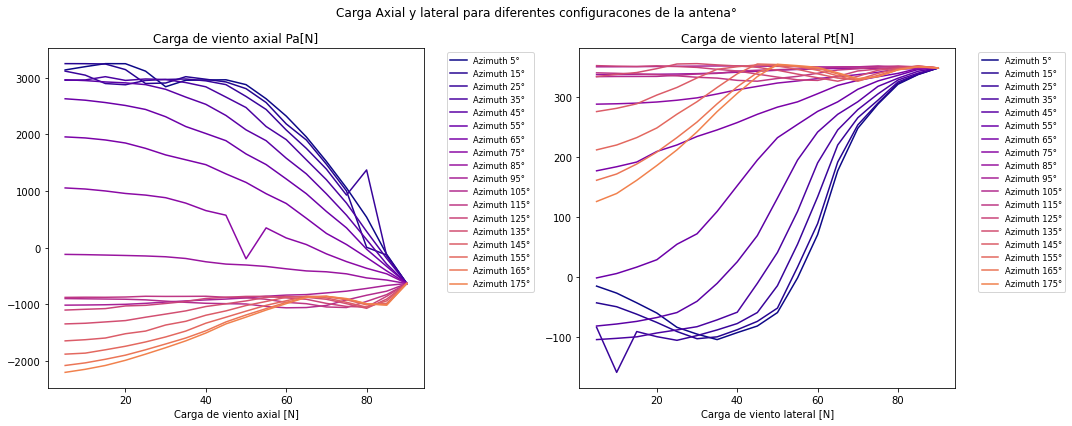

In [15]:
        #Calculo de las fuerzas para las diferentes posiciones planteadas de la antena


    #Parametros de viento y lugar 
rho_v = 1.173 #Densidad del aire humedo a 25°C, R = 0.7, P = 101.190 Kpa
v = 100 #Velocidad máxima del viento en Km/h en los ultimos 10 años segun IDEAM 
v_m = v*(1000/3600)

Din_P = (1/2)*rho_v*(v_m)**2 #Presion dinámica del viento a la velocidad definida

    #Cálculo de la fuerza axial Pa 
Pa_df = Din_P*A_ref*Ax_coef_df

Pa = np.empty((len(beta),len(alpha)))
for i in range(len(beta)):
    Pa[i,:] = Din_P*A_ref*Ax_coef_att[i,:]

    #Cálculo de la fuerza transversal Pt
Pt_df = Din_P*A_ref*Lat_coef_df
Pt = np.empty((len(beta),len(alpha)))
for i in range(len(beta)):
    Pt[i,:] = Din_P*A_ref*Lat_coef_att[i,:]
    
    #Cálculo de la fuerza en el eje x para cada posición de la antena 
Fx = np.empty((len(beta),len(alpha))) 
for i in range(len(beta)):
    A = Pa[i,:]*np.sin(np.deg2rad(beta[i]))
    B = Pt[i,:]*(1/np.sin(np.deg2rad(gamma.T[i,:])))*np.cos(np.deg2rad(alpha))*np.cos(np.deg2rad(beta[i]))**2
    Fx[i,:] = A + B    
    
        #Cálculo de la fuerza en el eje y para cada posición de la antena 
Fy = np.empty((len(beta),len(alpha))) 
for i in range(len(beta)):
    A = 0
    B = Pt[i,:]*(1/np.sin(np.deg2rad(gamma.T[i,:])))*np.sin(np.deg2rad(alpha))
    Fy[i,:] = A - B      

        #Cálculo de la fuerza en el eje z para cada posición de la antena 
Fz = np.empty((len(beta),len(alpha)))
for i in range(len(beta)):
    A = Pa[i,:]*np.cos(np.deg2rad(beta[i]))
    B = Pt[i,:]*(1/np.sin(np.deg2rad(gamma.T[i,:])))*np.cos(np.deg2rad(alpha))*np.sin(np.deg2rad(beta[i]))*np.cos(np.deg2rad(beta[i]))
    Fz[i,:] = A + B   
        #Se crea un arreglo multidinemsional de dimensiones MxNx3 para las fuerzas

Forces = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    Forces[i,:,0] = Fx[i,:]
    Forces[i,:,1] = Fy[i,:]
    Forces[i,:,2] = Fz[i,:]
    

                                    #Cálculo de los momentos 
#Calculo de los momentos en x
Mx = np.empty((len(beta),len(alpha))) 
for i in range(len(beta)):
    A = Pt[i,:]*e
    B = 1/np.sin(np.deg2rad(gamma[:,i]))
    C = np.sin(np.deg2rad(alpha))
    D = np.cos(np.deg2rad(beta[i]))
    Mx[i,:] = A*B*C*D
    
#Calculo de los momentos en y
My = np.empty((len(beta),len(alpha))) 
for i in range(len(beta)):
    A = Pt[i,:]*e
    B = 1/np.sin(np.deg2rad(gamma[:,i]))
    C = np.cos(np.deg2rad(alpha))
    D = np.cos(np.deg2rad(beta[i]))
    My[i,:] = A*B*C*D  

#Calculo de los momentos en z
Mz = np.empty((len(beta),len(alpha))) 
for i in range(len(beta)):
    A = Pt[i,:]*e
    B = 1/np.sin(np.deg2rad(gamma[:,i]))
    C = np.sin(np.deg2rad(alpha))
    D = np.sin(np.deg2rad(beta[i]))
    Mz[i,:] = A*B*C*D  

#Creación del arreglo de momentos 
Moments = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    Moments[i,:,0] = Mx[i,:]
    Moments[i,:,1] = My[i,:]
    Moments[i,:,2] = Mz[i,:]


                                    #Gráfica de la carga axial y lateral de la antena
fig = plt.figure(figsize=(15,6), tight_layout = True)
gs = fig.add_gridspec(1,2)
fig.suptitle("Carga Axial y lateral para diferentes configuracones de la antena°")
pa_plt = fig.add_subplot(gs[0,0])
pt_plt = fig.add_subplot(gs[0,1])
ilist = range(0,35,2)
#se crea la paleta de colores a partir de cmap 'viridis'
cmap=plt.get_cmap('plasma')
pallete = []
for n in np.linspace(0,1,50):
    pallete.append(cmap(n))

for i in ilist:
    pa_plt.plot(90-beta,Pa[:,i], label = "Azimuth " + str(alpha[i])+"°",color = pallete[i])
    pa_plt.set_xlabel("Carga de viento axial [N]")
    pa_plt.legend(bbox_to_anchor=(1.05, 1.0), loc = 2,fontsize='small')
    pa_plt.set_title("Carga de viento axial Pa[N]")
    
for i in ilist:
    pt_plt.plot(90-beta,Pt[:,i], label = "Azimuth " + str(alpha[i])+"°",color = pallete[i])
    pt_plt.set_xlabel("Carga de viento lateral [N]")
    pt_plt.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    pt_plt.set_title("Carga de viento lateral Pt[N]")




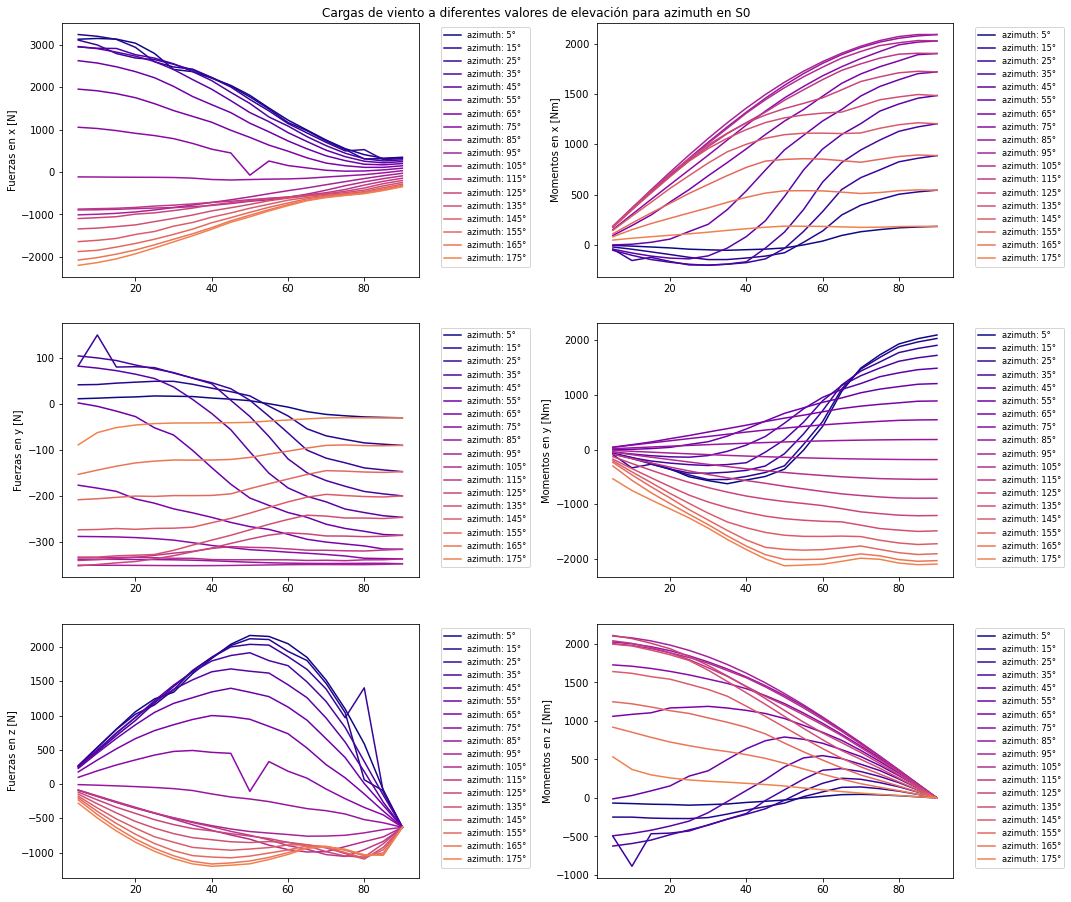

In [16]:
        #Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S0
fig = plt.figure(figsize =(15,13),tight_layout = True)
gs = fig.add_gridspec(3,2)
fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth en S0")

Fx_0= fig.add_subplot(gs[0,0])
Fy_0 = fig.add_subplot(gs[1,0])
Fz_0 = fig.add_subplot(gs[2,0])
Mx_0 = fig.add_subplot(gs[0,1])
My_0 = fig.add_subplot(gs[1,1])
Mz_0 = fig.add_subplot(gs[2,1])


ilist = range(0,35,2) 
for i in ilist:
    Fx_0.plot(90 - beta,Forces[:,i,0],label = "azimuth: " + str(alpha[i])+ "°", color = pallete[i])
    Fx_0.set_ylabel("Fuerzas en x [N]")
    Fx_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
for i in ilist:
    Fy_0.plot(90 - beta,Forces[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Fy_0.set_ylabel("Fuerzas en y [N]")
    Fy_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Fz_0.plot(90 - beta,Forces[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Fz_0.set_ylabel("Fuerzas en z [N]")
    Fz_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mx_0.plot(90 - beta,Moments[:,i,0],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Mx_0.set_ylabel("Momentos en x [Nm]")
    Mx_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    My_0.plot(90 - beta,Moments[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    My_0.set_ylabel("Momentos en y [Nm]")
    My_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mz_0.plot(90 - beta,Moments[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Mz_0.set_ylabel("Momentos en z [Nm]")
    Mz_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

In [17]:
i = 0 #index de alpha
j = 0 #index de beta
print(
    "---------------------------Estado de fuerzas S0----------------------------------------","\n"
    "Distancia a la cual se aplican fuerzas e: ", e,
    "\n",
    "alpha: ", alpha[i],
    "\n",
    "beta: ", beta[j],
    "\n"
    "theta: ", 90 - beta[j],
    "\n",
    "Gamma: ", gamma_df.loc[beta[j],alpha[i]],
    "\n",
    "Pa: ", Pa[j,i],
    "\n",
    "Pt: ", Pt[j,i],
    "\n",
    "Fuerza en x: ", Forces[j,i,0],
    "\n",
    "Fuerza en y: ", Forces[j,i,1],
    "\n",
    "Fuerza en z: ", Forces[j,i,2],
    "\n",
    "Momento en x: ", Moments[j,i,0],
    "\n",
    "Momento en y: ", Moments[j,i,1],
    "\n",
    "Momento en z: ", Moments[j,i,2],

)

---------------------------Estado de fuerzas S0---------------------------------------- 
Distancia a la cual se aplican fuerzas e:  6.033333333333333 
 alpha:  5 
 beta:  0 
theta:  90 
 Gamma:  90.0 
 Pa:  -630.3835125380562 
 Pt:  347.9351285549153 
 Fuerza en x:  346.6111303462765 
 Fuerza en y:  -30.32454455720557 
 Fuerza en z:  -630.3835125380562 
 Momento en x:  182.95808549514027 
 Momento en y:  2091.220486422535 
 Momento en z:  0.0


Las fuerzas anteriormente cálculadas están en un marco de referencia S0, por lo tanto se pasaran las fuerzas a un marco de refencia S2, Para ello se harán las siguientes conversiones
1. S0 $\rightarrow$ S1
2. S1 $\rightarrow$ S2
3. S2 $\rightarrow$ S3

In [18]:
                            #Se establecen las relaciones entre los 4 sistemas coordenadso
R10 = np.array([
    [0,-1,0],
    [-1,0,0],
    [0,0,1]
])
R21 = np.array([
    [0,0,1],
    [1,0,0],
    [0,1,0]
])

R32 = np.array([
    [1,0,0],
    [0,0,-1],
    [0,1,0]
])

#R32 = np.dot(Rot_y2,R32) la matriz R32 depende del angulo de elevaccion por lo que se premultiplica por Rot(y2,theta)


In [19]:
                                #Transformación de las fuerzas entre coordenadas LH a coordenadas 1 
                                #Las coordenadas 1 son las expresadas en la descripción anterior
#En forces_S0 están las fuerzas expresadas en el sistema coordenado left-handed (S0)
Forces_S0 = Forces
Forces_S1 = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    for j in range(len(alpha)):
        Forces_S1[i,j] = np.dot(R10,Forces_S0[i,j].T)
        
#Rotar el eje coordenado para que el eje y sea el eje de elevación, el eje z sea el eje de simetria de la antena y el eje x sea perpendicular y forme un plano horizontal con el eje y
# Forces_S1 es la copia de Forces en donde el eje x era el eje de elevación

Forces_S2 = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    for j in range(len(alpha)):
        Forces_S2[i,j] = np.dot(R21,Forces_S1[i,j].T)

        #Transformación de las fuerzas entre coordenadas LH a coordenadas 1 
#En forces_copy están las fuerzas expresadas en el sistema coordenado left-handed
Moments_S0 = Moments

#La matriz cambia debido a que los momentos expresados también en el eje coordenado lefthanded están dados por la regla
#de la mano derecha

R10_m = np.array([
    [0,1,0],
    [1,0,0],
    [0,0,-1]
])
Moments_S1 = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    for j in range(len(alpha)):
        Moments_S1[i,j] = np.dot(R10_m,Moments_S0[i,j].T)
        
# Forces_copy_xele es la copia de Forces en donde el eje x era el eje de elevación
Moments_S2 = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    for j in range(len(alpha)):
        Moments_S2[i,j] = np.dot(R21,Moments_S1[i,j].T)

# print("---------------------------------------------------------------")      
# print("theta: ", 90 - beta[15],"\n",
# "alpha: ", alpha[0],"\n","beta: ",beta[15])
# print(Forces_copy_xele[15,0],"\n", Forces[15,0],"\n",Forces_copy[15,0])
# print("---------------------------------------------------------------")  
# print(Moments_copy_xele[15,0],"\n", Moments[15,0],"\n",Moments_copy[15,0])




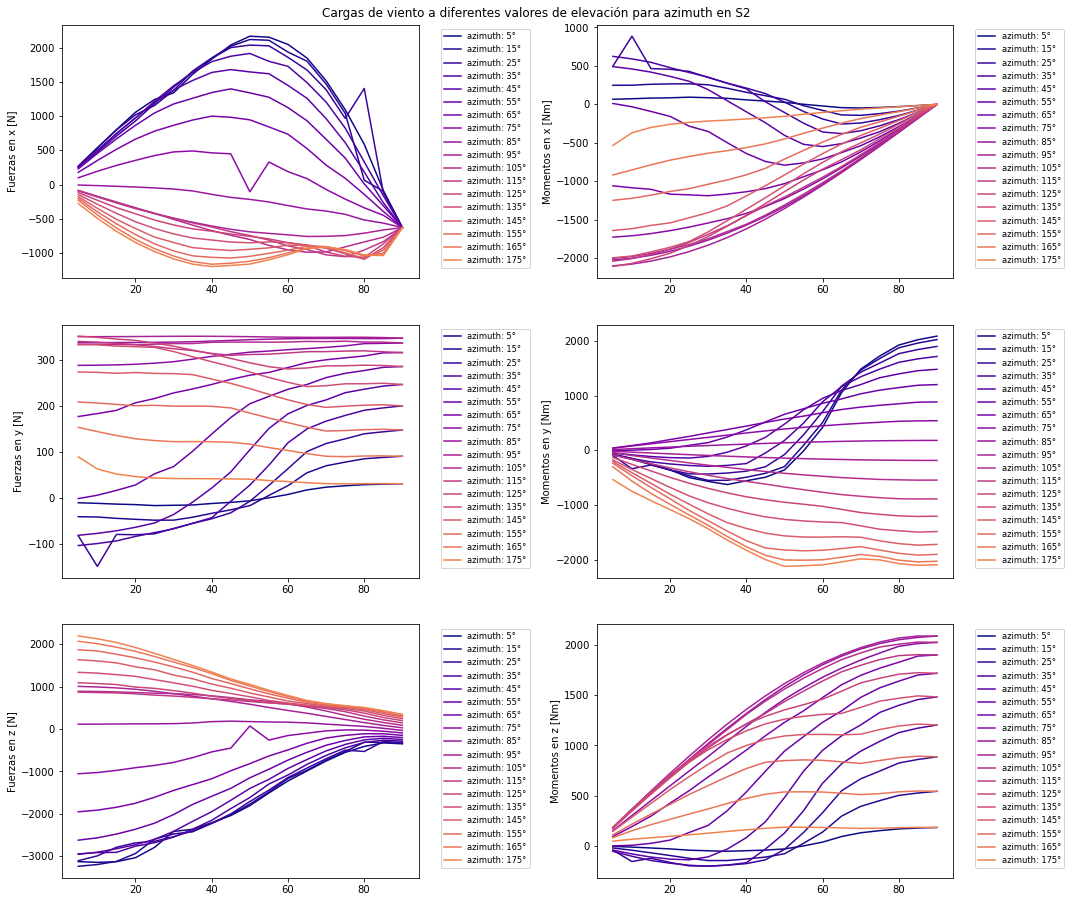

In [20]:
        #Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S2
fig = plt.figure(figsize =(15,13),tight_layout = True)
gs = fig.add_gridspec(3,2)
fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth en S2")

Fx_1= fig.add_subplot(gs[0,0])
Fy_1 = fig.add_subplot(gs[1,0])
Fz_1 = fig.add_subplot(gs[2,0])
Mx_1 = fig.add_subplot(gs[0,1])
My_1 = fig.add_subplot(gs[1,1])
Mz_1 = fig.add_subplot(gs[2,1])


ilist = range(0,35,2) 
for i in ilist:
    Fx_1.plot(90 - beta,Forces_S2[:,i,0],label = "azimuth: " + str(alpha[i])+ "°", color = pallete[i])
    Fx_1.set_ylabel("Fuerzas en x [N]")
    Fx_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
for i in ilist:
    Fy_1.plot(90 - beta,Forces_S2[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Fy_1.set_ylabel("Fuerzas en y [N]")
    Fy_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Fz_1.plot(90 - beta,Forces_S2[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Fz_1.set_ylabel("Fuerzas en z [N]")
    Fz_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mx_1.plot(90 - beta,Moments_S2[:,i,0],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Mx_1.set_ylabel("Momentos en x [Nm]")
    Mx_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    My_1.plot(90 - beta,Moments_S2[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    My_1.set_ylabel("Momentos en y [Nm]")
    My_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mz_1.plot(90 - beta,Moments_S2[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Mz_1.set_ylabel("Momentos en z [Nm]")
    Mz_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

In [21]:
i = 0 #index de alpha
j = 15 #index de beta
print(
    "---------------------------Estado de fuerzas S2----------------------------------------","\n"
    "Distancia a la cual se aplican fuerzas e: ", e,
    "\n",
    "alpha: ", alpha[i],
    "\n",
    "beta: ", beta[j],
    "\n"
    "theta: ", 90 - beta[j],
    "\n",
    "Gamma: ", gamma_df.loc[beta[j],alpha[i]],
    "\n",
    "Pa: ", Pa[j,i],
    "\n",
    "Pt: ", Pt[j,i],
    "\n",
    "Fuerza en x: ", Forces_S2[j,i,0],
    "\n",
    "Fuerza en y: ", Forces_S2[j,i,1],
    "\n",
    "Fuerza en z: ", Forces_S2[j,i,2],
    "\n",
    "Momento en x: ", Moments_S2[j,i,0],
    "\n",
    "Momento en y: ", Moments_S2[j,i,1],
    "\n",
    "Momento en z: ", Moments_S2[j,i,2],

)

---------------------------Estado de fuerzas S2---------------------------------------- 
Distancia a la cual se aplican fuerzas e:  6.033333333333333 
 alpha:  5 
 beta:  75 
theta:  15 
 Gamma:  15.79322415135941 
 Pa:  3250.149264883156 
 Pt:  -43.39190030006026 
 Fuerza en x:  801.4943304180489 
 Fuerza en y:  -13.895369052712654 
 Fuerza en z:  -3128.7638703529074 
 Momento en x:  80.97877153079254 
 Momento en y:  -248.0115201361008 
 Momento en z:  -21.69819643574025


In [22]:
#Comprobación de las matrices de rotación de S2 a S2 deberia ser
#                     [0,0,0]
#               R20 = [0,-1,0]
#                     [-1,0,0]

R20 = np.dot(R21,R10)
R20

array([[ 0,  0,  1],
       [ 0, -1,  0],
       [-1,  0,  0]])

#### Conversión de sistemas de referencias para las cargas de viento presentadas en [3] 

Para realizar la determinación de las cargas aerodinámicas para diferentes posiciones de la antena se util tener los wrenches en un dataframe indexado por valores de elevación y nombres de columnas como valores de azimut, así pues para acceder al wrench de carga de vientos cuando el azimut $\alpha = 5°$ y la elevación $\beta = 0$ se teclea New_Wrench.loc[0,5]

In [23]:
#Transformación de las fuerzas al sistema coordenado de cuerpo Body Frame 
def Rot_y2(theta):
    y2_theta = [0,1,0,np.deg2rad(theta)]
    Rot_y2 = pr_rot.matrix_from_axis_angle(a = y2_theta)
    return Rot_y2

Forces_S3 = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    for j in range(len(alpha)):
        Forces_S3[i,j] = np.dot(np.dot(R32,Rot_y2(90-beta[i])),Forces_S2[i,j].T)
        
Moments_S3 = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    for j in range(len(alpha)):
        Moments_S3[i,j] = np.dot(np.dot(R32,Rot_y2(90-beta[i])),Moments_S2[i,j].T)
        
        

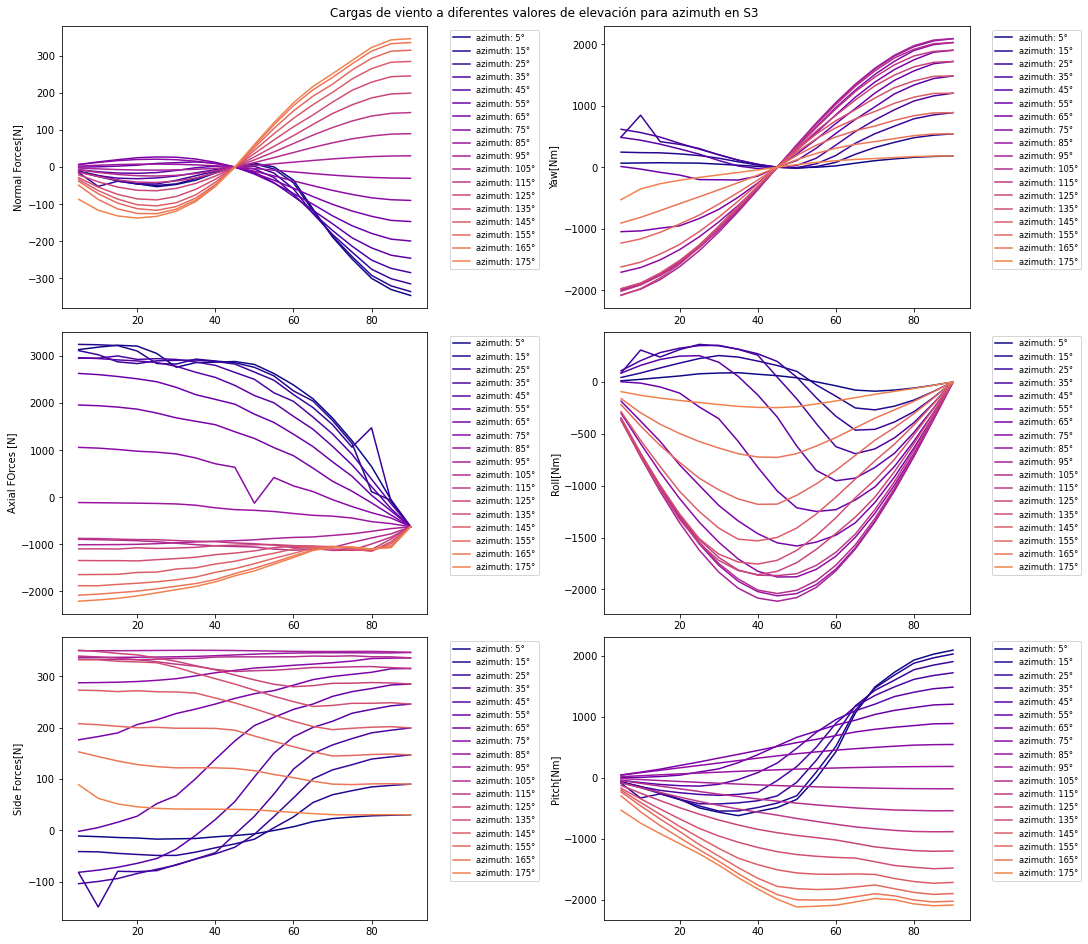

In [24]:
        #Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S2
fig = plt.figure(figsize =(15,13),constrained_layout = True)
gs = fig.add_gridspec(3,2)
fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth en S3")

Fx_1= fig.add_subplot(gs[0,0])
Fy_1 = fig.add_subplot(gs[1,0])
Fz_1 = fig.add_subplot(gs[2,0])
Mx_1 = fig.add_subplot(gs[0,1])
My_1 = fig.add_subplot(gs[1,1])
Mz_1 = fig.add_subplot(gs[2,1])


ilist = range(0,35,2) 
for i in ilist:
    Fx_1.plot(90 - beta,Forces_S3[:,i,0],label = "azimuth: " + str(alpha[i])+ "°", color = pallete[i])
    Fx_1.set_ylabel("Normal Forces[N]")
    Fx_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
for i in ilist:
    Fy_1.plot(90 - beta,Forces_S3[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Fy_1.set_ylabel("Axial FOrces [N]")
    Fy_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Fz_1.plot(90 - beta,Forces_S3[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Fz_1.set_ylabel("Side Forces[N]")
    Fz_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mx_1.plot(90 - beta,Moments_S3[:,i,0],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Mx_1.set_ylabel("Yaw[Nm]")
    Mx_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    My_1.plot(90 - beta,Moments_S3[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    My_1.set_ylabel("Roll[Nm]")
    My_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mz_1.plot(90 - beta,Moments_S3[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
    Mz_1.set_ylabel("Pitch[Nm]")
    Mz_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

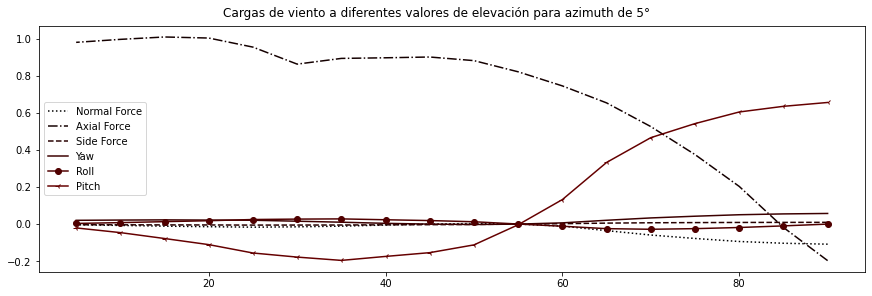

In [25]:
        #Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S3
Forces_coef = np.empty((len(beta),len(alpha),3))
Forces_coef = (1/(Din_P*A_ref))*Forces_S3

Moments_coef = np.empty((len(beta),len(alpha),3))
Moments_coef = (1/(Din_P*A_ref*D))*Moments_S3
cmap2=plt.get_cmap('gist_heat')
pallete2 = []
for n in np.linspace(0,1,20):
    pallete2.append(cmap2(n))
    
fig = plt.figure(figsize =(12,4),constrained_layout = True)

fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth de 5°")
ax_5 = plt.subplot()

ax_5.plot(90 - beta,Forces_coef[:,0,0],color = pallete2[0],label ='Normal Force',linestyle='dotted')
ax_5.plot(90 - beta,Forces_coef[:,0,1],color = pallete2[1], label = 'Axial Force',linestyle='dashdot')
ax_5.plot(90 - beta,Forces_coef[:,0,2],color = pallete2[2], label = 'Side Force',linestyle='dashed')
ax_5.plot(90 - beta,Moments_coef[:,0,0],color = pallete2[3], label ='Yaw',linestyle='solid')
ax_5.plot(90 - beta,Moments_coef[:,0,1],color = pallete2[4], label ='Roll',marker='o')
ax_5.plot(90 - beta,Moments_coef[:,0,2],color = pallete2[5], label ='Pitch',marker='3')
ax_5.legend()
    


#### Verificación de datos calculados con [2] respecto a [3] 
Se hará los cálculos para:
* **alpha** = 5,20,40,45,60,75,90,120,140,170,180
* **Elev** = 5,20,40,45,60,75,90

Los cálculos se presentarán como un error en coeficiente y en torque

In [26]:
search_alpha = np.array([5,20,40,45,60,75,90,120,140,170,180])
alpha_index = []
elev_index = []
theta_v = 90 - beta #trasnformamos los valores de beta a valores de elevación
search_theta = np.array([5,20,40,45,60,75,90])
#Se encuentran los valores de los indices en donde están theta
for i in range(len(search_alpha)):
    index33 = np.where(alpha == search_alpha[i])
    alpha_index.append(index33[0][0])
alpha_index = np.array(alpha_index)
#Se encuentran los valores de los indices en donde está theta
for i in range(len(search_theta)):
    index33 = np.where(theta_v == search_theta[i])
    elev_index.append(index33[0][0])
elev_index = np.array(elev_index)

#Array de coeficientes de fuerzas según tunel Data, en orden Normal, Axial y Side
ff_TD = np.array([
    [[0.005,0.821,0.002],[0.054,0.805,0.011],[0.149,0.665,0.024],[0.173,0.611,0.025],[0.228,0.485,0.023],[0.218,0.220,0.020],[0.204,-0.056,0.019]],
    [[0.012,0.788,0.045],[0.064,0.766,0.066],[0.159,0.666,0.092],[0.182,0.623,0.092],[0.221,0.472,0.089],[0.206,0.239,0.081],[0.202,-0.046,0.074]],
    [[0.016,0.702,0.163],[0.062,0.672,0.179],[0.134,0.577,0.180],[0.150,0.549,0.177],[0.173,0.420,0.164],[0.165,0.205,0.145],[0.150,-0.020,0.132]],
    [[0.016,0.675,0.190],[0.059,0.647,0.204],[0.127,0.560,0.201],[0.141,0.541,0.196],[0.159,0.427,0.178],[0.154,0.210,0.160],[0.139,-0.030,0.148]],
    [[0.014,0.481,0.228],[0.041,0.455,0.232],[0.086,0.639,0.221],[0.093,0.343,0.216],[0.100,0.241,0.195],[0.095,0.110,0.173],[0.082,-0.020,0.159]],
    [[0.008,0.220,0.218],[0.022,0.206,0.219],[0.038,0.171,0.213],[0.040,0.158,0.209],[0.035,0.110,0.189],[0.037,0.070,0.176],[0.039,-0.040,0.161]],
    [[0.004,-0.069,0.162],[0.003,-0.054,0.162],[0.002,-0.039,0.158],[0.002,-0.037,0.156],[0.002,-0.033,0.148],[0.003,-0.032,0.149],[0.001,-0.042,0.153]],
    [[-0.016,-0.250,0.242],[-0.034,-0.255,0.232],[-0.059,-0.227,0.209],[-0.062,-0.216,0.202],[-0.071,-0.178,0.175],[-0.076,-0.072,0.157],[-0.082,-0.020,0.159]],
    [[-0.031,-0.453,0.214],[-0.075,-0.423,0.205],[-0.122,-0.249,0.175],[-0.131,-0.232,0.166],[-0.143,-0.190,0.141],[-0.142,-0.128,0.127],[-0.150,-0.020,0.132]],
    [[-0.018,-0.698,0.043],[-0.106,-0.645,0.040],[-0.158,-0.480,0.040],[-0.173,-0.430,0.040],[-0.199,-0.280,0.040],[-0.206,-0.211,0.040],[-0.211,-0.003,0.040]],
    [[-0.036,-0.850,-0.001],[-0.124,-0.785,-0.001],[-0.208,-0.579,0.000],[-0.217,-0.508,0.000],[-0.207,-0.320,-0.001],[-0.184,-0.193,-0.002],[-0.197,-0.050,-0.002]]
])
ff_TD = ff_TD.T

Forces_TD = (1/(1/(Din_P*A_ref)))*ff_TD

#Array de coeficientes de momentos según tunel Data, en orden Pitch, Roll, Yaw
Mf_TD = np.array([
    [[0.027,-0.002,0.000],[0.029,-0.001,-0.001],[0.025,-0.001,0.000],[0.026,0.000,0.001],[0.046,-0.001,0.010],[0.063,0.000,0.011],[0.064,-0.002,0.010]],
    [[0.031,-0.001,0.001],[0.019,0.000,-0.001],[0.021,-0.001,0.000],[0.026,0.000,0.005],[0.042,0.000,0.027],[0.053,0.000,0.030],[0.056,-0.001,0.029]],
    [[0.021,0.001,0.019],[0.014,0.004,0.021],[0.005,0.001,0.021],[0.005,0.000,0.025],[0.023,0.000,0.040],[0.031,0.001,0.044],[0.028,0.000,0.045]],
    [[0.019,0.002,0.028],[0.016,0.005,0.032],[0.001,0.002,0.031],[0.000,-0.001,0.035],[0.021,0.002,0.051],[0.033,-0.001,0.056],[0.027,0.001,0.057]],
    [[0.042,0.000,0.056],[0.040,0.006,0.064],[0.029,0.003,0.070],[0.052,0.000,0.069],[0.015,0.002,0.054],[0.012,0.000,0.043],[0.017,0.000,0.044]],
    [[0.024,0.003,0.067],[0.010,0.002,0.063],[0.000,0.001,0.063],[0.001,0.001,0.064],[0.008,0.002,0.068],[0.003,-0.002,0.071],[-0.013,0.002,0.072]],
    [[0.016,0.001,0.044],[0.005,0.001,0.040],[-0.002,-0.001,0.035],[-0.002,0.001,0.035],[0.001,0.001,0.041],[0.000,0.001,0.038],[-0.002,-0.001,0.038]],
    [[0.003,-0.005,0.100],[0.000,0.000,0.098],[-0.009,-0.002,0.087],[-0.013,0.004,0.083],[-0.021,-0.003,0.069],[-0.023,0.001,0.054],[-0.017,0.000,0.044]],
    [[-0.005,-0.002,0.079],[-0.014,-0.001,0.077],[-0.034,0.000,0.070],[-0.038,-0.001,0.066],[-0.031,0.003,0.055],[-0.028,0.000,0.048],[-0.028,0.000,0.045]],
    [[0.015,0.000,0.022],[-0.006,-0.002,0.022],[-0.042,0.002,0.022],[-0.049,-0.002,0.022],[-0.063,0.000,0.023],[-0.068,-0.001,0.022],[-0.066,-0.002,0.021]],
    [[0.038,-0.001,0.002],[0.011,0.000,0.002],[-0.055,0.002,-0.001],[-0.065,-0.003,0.000],[-0.071,0.000,0.002],[-0.067,-0.002,-0.002],[-0.062,-0.002,-0.001]]
])

Mf_TD = Mf_TD.T
Moments_TD = (Din_P*A_ref*D)*Mf_TD
Forces_TD.shape

(3, 7, 11)

In [27]:
ff = np.empty((len(elev_index),len(alpha_index),3))
for i in range(len(elev_index)):
    for j in range(len(alpha_index)):
        ff[i,j]=ff_TD[:,i,j]
Mff = np.empty((len(elev_index),len(alpha_index),3))
for i in range(len(elev_index)):
    for j in range(len(alpha_index)):
        Mff[i,j]=Mf_TD[:,i,j]
Mff[:,:,[0,2]] = Mff[:,:,[2,0]]
ff_forces = (Din_P*A_ref)*ff
Mf_Moments = (Din_P*A_ref*D)*Mff



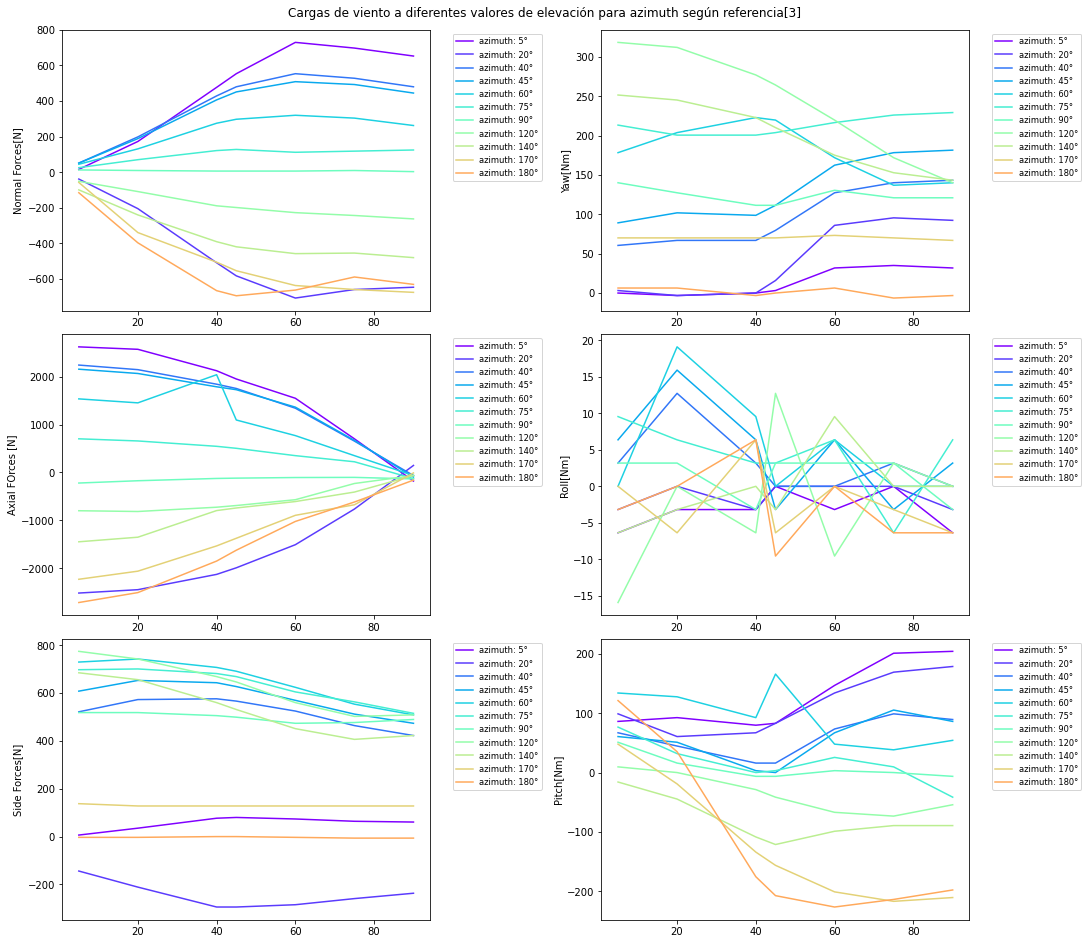

In [37]:
        #Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S2
fig = plt.figure(figsize =(15,13),constrained_layout = True)
gs = fig.add_gridspec(3,2)
fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth según referencia[3]")

Fx_1= fig.add_subplot(gs[0,0])
Fy_1 = fig.add_subplot(gs[1,0])
Fz_1 = fig.add_subplot(gs[2,0])
Mx_1 = fig.add_subplot(gs[0,1])
My_1 = fig.add_subplot(gs[1,1])
Mz_1 = fig.add_subplot(gs[2,1])

cmap=plt.get_cmap('rainbow')
pallete = []
for n in np.linspace(0,1,14):
    pallete.append(cmap(n))

ilist = range(len(alpha_index)) 
for i in ilist:
    Fx_1.plot(search_theta,Forces_TD[0,:,i],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°", color = pallete[i])
    Fx_1.set_ylabel("Normal Forces[N]")
    Fx_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
for i in ilist:
    Fy_1.plot(search_theta,Forces_TD[1,:,i],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Fy_1.set_ylabel("Axial FOrces [N]")
    Fy_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Fz_1.plot(search_theta,Forces_TD[2,:,i],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Fz_1.set_ylabel("Side Forces[N]")
    Fz_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mx_1.plot(search_theta,Moments_TD[2,:,i],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Mx_1.set_ylabel("Yaw[Nm]")
    Mx_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    My_1.plot(search_theta,Moments_TD[1,:,i],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    My_1.set_ylabel("Roll[Nm]")
    My_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mz_1.plot(search_theta,Moments_TD[0,:,i],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Mz_1.set_ylabel("Pitch[Nm]")
    Mz_1.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

In [29]:
Forces_TD[:,:,1] = (-1)*Forces_TD[:,:,1]

#### Representación de las cargas de viento en S4

Con el fin de disponer de las cargas de viento del radiotelescopio Hay-Stack se trasladan las fuerzas al sistema de referencia S4 que se describirá a continuación, este sistema coordenado es un sistema coordenado atado a la antena, cuyo eje z siempre será el eje de simetria de la antena en dirección al apuntamiento, y el eje y siempre será el eje de elevación de esta, así pues: 

* **Eje x**: Perpendicular al eje de elevación y simetría
* **Eje y**: Es el eje de elevación el cuál está siempre en un plano horizontal
* **Eje z**: Es un eje que siempre está en el eje de simetria de la antenna, con la mismo sentido que el apuntamiento. 

Este sistema coordenado para el análisis cinemático de la antena es el que se representa por $\{ C \}$ en **Antenna Kinematics**

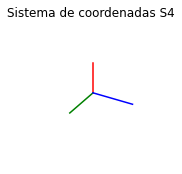

In [30]:
fig = plt.figure(figsize=(2,2))
R = np.array([
    [0,0,1],
    [0,-1,0],
    [1,0,0]
])
ax2 = pr_rot.plot_basis(R = R)
pr_plot.remove_frame(ax2)
ax2.set_title("Sistema de coordenadas S4")
plt.show()

#### Rotación de fuerzas y momentos a S4

Con el fin de lograr el objetivo anteriormente planteado se debe realizar la rotación respectiva mediante


                        [1,0,0]
                 R43 =  [0,0,1]
                        [0,-1,0]



In [31]:
R43 = np.array([
    [1,0,0],
    [0,0,1],
    [0,-1,0]
])
        #Transformación de fuerzas de S3 a S4
Forces_S4 = np.empty((len(beta),len(alpha),3))

for i in range(len(beta)):
    for j in range(len(alpha)):
        Forces_S4[i,j] = np.dot(R43,Forces_S3[i,j].T)
        

        #Transformación de momentos de S3 a S4
Moments_S4 = np.empty((len(beta),len(alpha),3))
for i in range(len(beta)):
    for j in range(len(alpha)):
        Moments_S4[i,j] = np.dot(R43,Moments_S3[i,j].T)
        
                #Transformación de fuerzas segun referencia 3  a S4
Forces_S4_TD = np.empty((len(elev_index),len(alpha_index),3))

for i in range(len(elev_index)):
    for j in range(len(alpha_index)):
        Forces_S4_TD[i,j] = np.dot(R43,ff_forces[i,j].T)
        

        #Transformación de momentos de S3 a S4
Moments_S4_TD = np.empty((len(elev_index),len(alpha_index),3))
for i in range(len(elev_index)):
    for j in range(len(alpha_index)):
        Moments_S4_TD[i,j] = np.dot(R43,Mf_Moments[i,j].T)
        

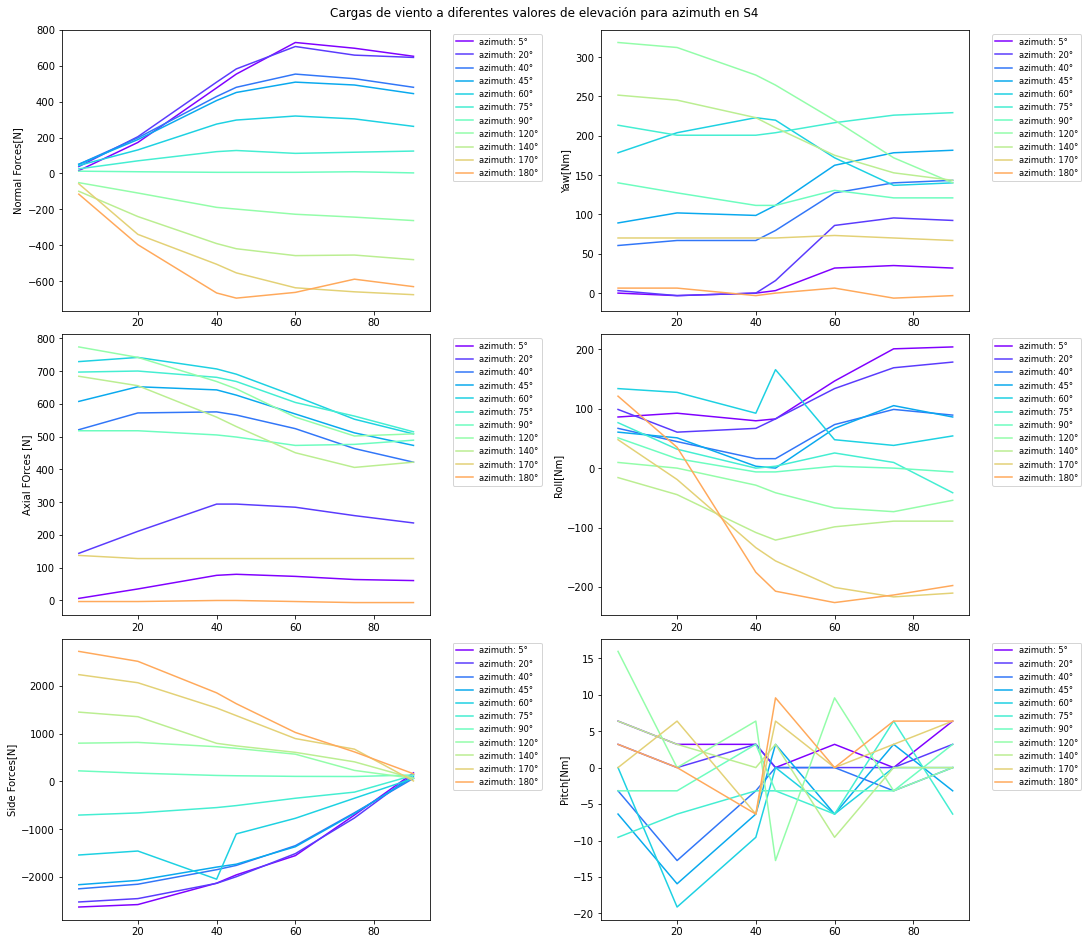

In [38]:
        #Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S4
fig = plt.figure(figsize =(15,13),constrained_layout = True)
gs = fig.add_gridspec(3,2)
fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth en S4")

Fx_4= fig.add_subplot(gs[0,0])
Fy_4 = fig.add_subplot(gs[1,0])
Fz_4 = fig.add_subplot(gs[2,0])
Mx_4 = fig.add_subplot(gs[0,1])
My_4 = fig.add_subplot(gs[1,1])
Mz_4 = fig.add_subplot(gs[2,1])


ilist = range(len(alpha_index)) 
for i in ilist:
    Fx_4.plot(search_theta,Forces_S4_TD[:,i,0],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°", color = pallete[i])
    Fx_4.set_ylabel("Normal Forces[N]")
    Fx_4.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
for i in ilist:
    Fy_4.plot(search_theta,Forces_S4_TD[:,i,1],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Fy_4.set_ylabel("Axial FOrces [N]")
    Fy_4.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Fz_4.plot(search_theta,Forces_S4_TD[:,i,2],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Fz_4.set_ylabel("Side Forces[N]")
    Fz_4.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mx_4.plot(search_theta,Moments_S4_TD[:,i,0],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Mx_4.set_ylabel("Yaw[Nm]")
    Mx_4.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    My_4.plot(search_theta,Moments_S4_TD[:,i,1],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    My_4.set_ylabel("Roll[Nm]")
    My_4.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

for i in ilist:
    Mz_4.plot(search_theta,Moments_S4_TD[:,i,2],label = "azimuth: " + str(alpha[alpha_index[i]])+ "°",color = pallete[i])
    Mz_4.set_ylabel("Pitch[Nm]")
    Mz_4.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

In [39]:
        #Se crea un arreglo multidinemsional de dimensiones MxNx6 para los momentos
Wrench = np.empty((len(beta),len(alpha),6))

for i in range(len(beta)):
            Wrench[i,:,0:3] = Moments_S4[i,:]
            Wrench[i,:,3:6] = Forces_S4[i,:]

print("..................................... Verificacion de data..................................")
print("Momentos del arreglo Moments: " ,Moments_S4[13,48])
print("Momentos del arreglo Forces: ", Forces_S4[13,48])
print("Momentos y fuerzas del arreglo Forces: ", Wrench[13,48])

..................................... Verificacion de data..................................
Momentos del arreglo Moments:  [ 1273.75510717  -390.51637466 -1518.00222506]
Momentos del arreglo Forces:  [ -41.60537354 -328.4438403   904.51559395]
Momentos y fuerzas del arreglo Forces:  [ 1273.75510717  -390.51637466 -1518.00222506   -41.60537354
  -328.4438403    904.51559395]


In [40]:
#Creación de un arreglo de los Wrenches segun configuración
New_Wremch = []
for i in range(len(Wrench[0])):
    Vector_Line = []
    for j in range(len(Wrench)):
        Vector_Line.append(Wrench[j][i])
    New_Wremch.append(Vector_Line)
New_Wrench = pd.DataFrame(New_Wremch)
#Configuración de los index del data frame
New_Wrench.columns = beta
New_Wrench.index = alpha
New_Wrench = New_Wrench.T